This is evaluation for トキポナ1000文コーパス by ponaLM

PonaLM is still weak to evaluate correctly. So the fluency score might be wrong.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import os, sys, re, regex, nltk
sys.path.append("../../../ponansformer")
from ponans import Ponansformer
import matplotlib.pyplot as plt
import matplotlib.colors as colors
pd.set_option("display.max_colwidth", 1000)
pd.set_option('display.max_columns', 1000)

prepare toki pona language model and dictionary

In [2]:
with open('../../words.txt') as f:
    words = [word.rstrip() for word in f.readlines()]
    words = words[0:1] + ['*'] + words[1:]
    w2n = {w:i for i,w in enumerate(words)}

# for detect proper noun
def proper(word):
    return re.match(r'^([AIUEO]|[KSNPML][aiueo]|[TJ][aueo]|W[aie])n?(([ksnpml]?[aiueo]|[tj][aueo]|w[aie])n?)*$',word)

# for detect symbols
p_emoji = regex.compile(r'\p{Emoji=Yes}+')

def word_to_id(word):
    if word in w2n:
        return w2n[word]
    elif proper(word):
        return w2n['<Q>']
    elif word.isnumeric():
        return w2n['<NUM>']
    elif p_emoji.search(word):
        return w2n['<SYM>']
    else:
        assert mopu

In [3]:
model = Ponansformer(len(words),64,32,4,0)
model.load_state_dict(torch.load('../../../ponansformer/lm.model', map_location='cpu'))
model.eval()

Ponansformer(
  (embed): Embedder(
    (embed): Embedding(146, 128)
  )
  (posemb): PositionalEmbedding()
  (layers): Layers(
    (layers): Sequential(
      (0): Layer(
        (layer1): AttentionLayer(
          (attn): SelfAttention(
            (x2q): Linear(in_features=256, out_features=8192, bias=False)
            (x2k): Linear(in_features=256, out_features=8192, bias=False)
            (x2v): Linear(in_features=256, out_features=8192, bias=False)
            (x2o): Linear(in_features=8192, out_features=256, bias=False)
            (drop): Dropout(p=0, inplace=False)
          )
          (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (drop): Dropout(p=0, inplace=False)
        )
        (layer2): FeedForwardLayer(
          (ff): FeedForward(
            (linear1): Linear(in_features=256, out_features=1024, bias=True)
            (linear2): Linear(in_features=1024, out_features=256, bias=True)
            (drop): Dropout(p=0, inplace=False)
          )


code for evaluation

In [4]:
# Negotive Log Likelihhod
def NLL(raw):
    raw = [0] + raw + [0] 
    x = torch.tensor((np.tile(raw,(len(raw),1)) * (np.eye(len(raw))==0) + np.eye(len(raw)))).long()
    x = torch.stack([v[i] for i,v in enumerate(model(x))])
    lst = [-ten[pos].item() for pos, ten in zip(raw, x.detach().numpy())]
    return lst[1:-1]

# evaluate the score of sentences
def evaluate(sent, show=True):
    nlls = NLL([word_to_id(w) for w in sent])
    prob = [round(np.exp(-l)*100,2) for l in nlls] # probability = exp(-NLL)
    fluency = round(1/(1+np.mean(nlls)),3)         # fluency = 1 / (1 + ave(all NLL))
    if show:
        display(pd.DataFrame([prob + [fluency]], index=['prob'], columns=sent + ['Fluency']))
    return fluency

load corpus

In [5]:
sents = [sent.rstrip().split(' ') for sent in open('pona_corpus1000.txt')]
sents[0]

['mi', 'jan', 'Alito', '.']

evaluate fluency of each sentence

In [6]:
scores = []
for i, sent in enumerate(sents):
    print('#{:04}'.format(i+1))
    fluency = round(evaluate(sent,True),3)
    scores += [fluency]

#0001


,mi,jan,Alito,.,Fluency
prob,73.0,79.56,56.75,98.69,0.781


#0002


,ali,li,ike,tawa,ona,.,Fluency
prob,0.22,99.83,10.43,81.02,2.79,98.26,0.33


#0003


,tomo,mi,li,suli,ala,.,Fluency
prob,2.8,16.28,99.82,3.68,11.16,97.17,0.355


#0004


,mi,jo,ala,e,tomo,tawa,.,Fluency
prob,79.04,26.9,92.17,76.29,17.58,11.74,97.02,0.546


#0005


,mi,toki,kepeken,ilo,.,Fluency
prob,60.71,8.62,7.13,1.87,91.07,0.341


#0006


,tenpo,ni,la,mi,lon,supa,mi,.,Fluency
prob,89.04,37.21,99.44,86.3,43.81,0.63,5.54,97.98,0.443


#0007


,tomo,pali,mi,li,sin,.,Fluency
prob,7.05,2.08,34.28,98.75,0.39,97.34,0.313


#0008


,kon,li,seli,li,jo,e,telo,mute,.,Fluency
prob,0.99,2.25,1.19,38.67,20.23,99.32,7.88,11.71,97.69,0.309


#0009


,moku,mi,li,kili,palisa,.,Fluency
prob,1.27,25.89,97.44,0.04,0.02,98.51,0.211


#0010


,mi,jo,e,lipu,pi,toki,pali,.,Fluency
prob,79.14,17.47,99.79,4.6,77.71,2.06,0.14,96.09,0.336


#0011


,jan,meli,lili,ni,li,jo,e,palisa,nasa,.,Fluency
prob,7.16,0.39,11.7,12.28,99.94,27.72,99.78,0.42,3.38,96.03,0.307


#0012


,sina,moku,e,telo,nasa,la,sina,nasa,.,Fluency
prob,11.85,3.18,95.2,21.66,9.18,29.19,18.13,4.67,92.67,0.365


#0013


,mi,wile,ala,e,moku,jaki,.,Fluency
prob,82.47,29.39,3.5,87.57,2.67,0.09,94.7,0.31


#0014


,sina,seli,e,telo,la,telo,li,pana,e,kon,.,Fluency
prob,19.56,0.27,83.5,3.18,13.87,1.66,99.24,8.71,94.58,1.4,96.97,0.314


#0015


,ona,li,sitelen,e,sike,la,akesi,suli,li,kama,.,Fluency
prob,46.1,99.81,0.6,54.53,0.84,8.84,0.16,3.61,99.48,14.99,97.3,0.302


#0016


,sijelo,ona,li,lete,sama,kiwen,.,Fluency
prob,2.96,19.05,99.91,0.01,0.21,0.14,97.48,0.206


#0017


,mi,pana,e,ilo,musi,tawa,meli,mi,.,Fluency
prob,32.99,37.44,99.45,18.45,8.03,50.81,3.84,42.43,97.4,0.447


#0018


,sina,kute,ala,kute,e,kalama,ni,?,Fluency
prob,70.01,0.68,98.9,1.92,97.08,1.3,3.02,22.73,0.3


#0019


,pipi,mute,li,moku,e,kasi,laso,.,Fluency
prob,0.17,4.66,99.92,10.35,93.18,2.68,0.32,99.03,0.274


#0020


,waso,walo,lili,li,pona,tawa,mi,.,Fluency
prob,1.53,0.65,1.86,99.75,68.22,92.75,72.45,97.46,0.364


#0021


,kala,Opapinija,li,jo,e,oko,luka,.,Fluency
prob,0.01,4.56,99.96,49.39,99.13,0.34,0.49,97.4,0.251


#0022


,mi,esun,e,len,sin,.,Fluency
prob,59.73,0.12,97.39,0.83,1.2,98.09,0.266


#0023


,jan,Sonja,li,mama,pi,toki,pona,.,Fluency
prob,84.74,82.98,98.48,0.23,36.26,9.02,14.22,97.12,0.403


#0024


,jan,nasa,li,lon,monsi,sina,.,Fluency
prob,15.53,0.32,98.73,61.64,1.43,6.35,97.06,0.316


#0025


,jan,pali,pi,ma,ale,o,wan,.,Fluency
prob,5.7,1.22,74.16,2.95,0.28,0.26,0.32,97.59,0.218


#0026


,luka,tu,li,nanpa,pona,.,Fluency
prob,0.36,1.27,95.99,0.14,1.58,85.87,0.223


#0027


,ma,ni,li,pi,mi,.,Fluency
prob,8.31,14.32,80.89,0.18,2.82,97.04,0.292


#0028


,o,olin,e,mi,taso,.,Fluency
prob,11.91,1.59,90.98,8.34,1.81,91.3,0.317


#0029


,sina,moku,e,pan,suwi,mi,",",anu,seme,?,Fluency
prob,75.91,2.27,96.28,0.97,0.54,12.89,1.72,60.05,99.01,98.12,0.327


#0030


,mi,pana,e,ko,jaki,lon,tenpo,sona,la,tenpo,pi,tomo,sona,mi,li,pini,.,Fluency
prob,80.17,10.83,97.77,1.28,0.62,58.22,23.23,0.21,12.68,6.65,65.17,6.58,1.95,23.57,33.29,3.75,96.41,0.31


#0031


,mi,ken,ala,ken,tawa,tomo,telo,?,Fluency
prob,28.46,48.52,97.99,31.43,28.08,6.64,0.37,16.78,0.355


#0032


,akesi,linja,li,ike,tawa,sina,.,Fluency
prob,1.47,0.09,98.42,18.03,89.09,12.21,96.09,0.315


#0033


,kon,pona,li,kama,tan,ma,kasi,.,Fluency
prob,0.51,1.31,99.92,30.95,12.13,49.32,0.7,98.22,0.301


#0034


,telo,li,kama,tan,sewi,li,tawa,telo,suli,.,Fluency
prob,5.04,94.48,28.11,11.7,6.31,15.21,9.47,23.49,17.33,97.91,0.375


#0035


,kili,loje,en,kili,laso,li,suwi,.,Fluency
prob,0.29,0.53,4.73,0.28,0.16,98.0,0.33,98.07,0.199


#0036


,pan,li,lon,insa,poki,pimeja,.,Fluency
prob,0.16,98.94,66.87,3.62,0.72,2.53,97.53,0.272


#0037


,esun,mute,li,lon,ma,tomo,Tokijo,.,Fluency
prob,0.08,3.21,99.85,71.36,85.31,85.98,42.44,98.77,0.398


#0038


,ijo,ali,li,kama,ante,.,Fluency
prob,3.75,1.82,99.96,14.93,2.15,96.0,0.315


#0039


,jan,li,soweli,sona,.,Fluency
prob,4.56,72.65,0.12,0.12,96.62,0.228


#0040


,tan,seme,la,sina,olin,e,toki,Losupan,?,Fluency
prob,49.71,97.91,99.26,71.04,0.59,90.22,14.05,57.07,97.13,0.504


#0041


,sina,wile,e,ilo,sitelen,tawa,la,mi,alasa,e,mani,mute,.,Fluency
prob,12.14,11.13,88.16,51.4,10.35,12.41,80.34,76.58,0.17,97.32,12.27,24.3,96.19,0.395


#0042


,jan,mute,li,tawa,tomo,telo,li,telo,e,sijelo,ona,.,Fluency
prob,37.45,3.1,97.93,11.63,2.99,1.57,4.22,1.46,74.97,3.94,21.67,99.29,0.31


#0043


,mi,wile,lape,lon,supa,pona,suli,.,Fluency
prob,80.5,55.2,3.98,14.72,1.3,0.65,0.35,97.36,0.276


#0044


,tenpo,suno,sin,li,open,la,suno,li,kama,tan,monsi,pi,nena,weka,.,Fluency
prob,95.86,43.15,0.37,90.61,1.51,55.8,3.52,87.51,55.04,9.78,0.73,34.25,0.59,1.08,95.29,0.309


#0045


,sina,pali,e,moku,la,mi,pana,e,kili,anu,kasi,anu,kala,tawa,sina,.,Fluency
prob,21.41,3.67,90.29,0.5,39.17,63.23,34.03,99.29,0.63,0.39,0.46,0.54,0.04,58.99,21.35,91.67,0.267


#0046


,tomo,tawa,nanpa,luka,li,pi,jan,seme,?,Fluency
prob,45.62,4.59,0.32,0.25,0.7,3.63,29.25,97.0,87.86,0.262


#0047


,jan,Miku,li,ilo,kalama,musi,.,Fluency
prob,78.42,75.04,98.18,1.82,21.86,24.9,98.69,0.484


#0048


,kule,sewi,li,laso,.,Fluency
prob,0.72,2.45,97.28,0.23,98.46,0.253


#0049


,kasi,suli,suli,li,open,e,uta,la,ona,tawa,insa,kasi,.,Fluency
prob,2.2,8.07,2.76,99.95,1.03,94.39,0.11,28.83,3.05,8.25,0.32,1.79,97.58,0.253


#0050


,pipi,monsuta,li,lon,insa,mi,.,Fluency
prob,1.5,0.02,99.19,80.54,6.99,25.58,97.98,0.294


#0051


,sitelen,toki,pi,toki,Tawi,li,jo,e,sike,.,Fluency
prob,7.29,5.29,91.51,10.52,23.22,99.8,17.73,98.69,0.11,92.61,0.358


#0052


,sinpin,pi,meli,ni,li,pona,lukin,.,Fluency
prob,0.71,86.23,2.27,25.08,99.95,63.25,7.26,95.82,0.374


#0053


,ma,tu,li,open,e,utala,la,jan,mute,li,kama,moli,.,Fluency
prob,0.42,0.07,99.92,0.94,91.25,0.38,54.54,11.72,3.92,99.8,55.88,11.84,98.72,0.291


#0054


,supa,kiwen,li,kiwen,li,lete,.,Fluency
prob,0.86,0.5,3.94,0.57,7.01,1.6,97.06,0.217


#0055


,mi,pana,e,mani,mute,seme,la,mi,ken,esun,e,ilo,kipisi,ni,?,Fluency
prob,56.99,9.88,99.03,21.38,1.55,4.26,90.32,63.54,33.82,0.87,93.89,19.15,0.04,12.11,57.59,0.331


#0056


,mama,tu,mi,li,unpa,ala,la,mi,lon,ala,.,Fluency
prob,3.37,2.14,28.89,99.35,0.04,10.69,24.11,82.09,5.89,7.02,97.08,0.299


#0057


,tomo,pi,kulupu,pi,jan,sona,li,lon,ma,ni,.,Fluency
prob,3.98,70.66,2.56,79.43,11.55,0.06,58.16,78.92,44.07,2.88,98.44,0.332


#0058


,jan,Ototake,li,jo,ala,e,luka,en,noka,.,Fluency
prob,89.34,82.93,99.87,29.38,86.84,98.68,0.17,0.07,0.04,91.67,0.302


#0059


,tomo,tawa,pi,sitelen,tawa,ni,li,ilo,tawa,tenpo,.,Fluency
prob,22.24,17.21,78.2,6.33,35.6,5.69,89.2,0.66,11.38,0.11,94.53,0.311


#0060


,mi,sona,ala,e,nimi,sina,.,Fluency
prob,72.75,12.65,78.81,98.55,6.42,19.91,85.15,0.494


#0061


,o,kute,ala,e,kalama,musi,ike,.,Fluency
prob,31.62,2.91,83.34,95.62,41.38,18.79,1.16,90.7,0.399


#0062


,tenpo,ali,la,sina,jan,pona,mi,.,Fluency
prob,92.08,1.97,99.39,12.94,4.62,17.66,17.73,96.04,0.388


#0063


,jan,pi,pali,tomo,o,",",mi,lukin,e,sina,.,Fluency
prob,31.39,40.01,0.54,0.07,2.09,22.13,23.98,15.91,86.74,5.21,94.28,0.294


#0064


,sina,wile,ala,la,sina,moli,ala,.,Fluency
prob,37.61,22.18,6.21,18.83,27.48,0.32,13.46,46.12,0.323


#0065


,len,ni,li,sama,selo,jan,.,Fluency
prob,3.1,23.0,99.93,2.78,0.0,0.44,97.47,0.223


#0066


,soweli,Mekemeke,li,mu,lon,nasin,nasa,.,Fluency
prob,6.69,35.06,99.98,0.13,9.41,2.48,0.74,98.09,0.272


#0067


,ona,li,jo,e,luka,monsuta,li,tan,ma,anpa,.,Fluency
prob,60.8,99.96,20.36,98.68,1.07,0.03,0.31,3.16,2.39,0.19,98.38,0.244


#0068


,waso,Kopentan,li,pona,e,pilin,sina,.,Fluency
prob,0.15,22.38,99.82,1.13,49.43,3.8,8.39,95.41,0.296


#0069


,nimi,namako,li,nimi,pu,ala,.,Fluency
prob,3.06,0.0,74.83,0.1,0.02,1.96,91.24,0.17


#0070


,ma,Italija,li,jo,e,moku,pona,pona,.,Fluency
prob,0.59,73.24,99.82,37.1,99.59,1.45,0.24,0.6,90.66,0.291


#0071


,tenpo,pimeja,pi,ma,tomo,li,lete,.,Fluency
prob,60.16,5.21,14.39,55.97,1.92,37.93,0.95,97.78,0.339


#0072


,mi,open,e,uta,tomo,la,mi,lukin,e,mun,.,Fluency
prob,72.54,1.03,88.89,0.12,0.19,36.32,80.28,10.43,94.78,0.11,98.76,0.279


#0073


,o,lon,e,wile,sina,.,Fluency
prob,18.35,0.4,17.15,0.23,8.38,86.11,0.253


#0074


,ilo,pi,pana,moku,li,pakala,la,soweli,li,moli,.,Fluency
prob,1.98,58.29,0.22,1.3,39.23,1.32,57.91,1.44,97.83,2.54,98.19,0.277


#0075


,kala,pi,sike,pan,li,jo,e,noka,luka,tu,wan,.,Fluency
prob,0.23,87.82,4.56,0.28,99.78,41.31,99.11,1.23,3.1,33.68,13.89,97.36,0.307


#0076


,o,moli,ala,e,jan,pona,sina,.,Fluency
prob,22.52,0.23,74.11,90.06,19.69,31.88,17.82,86.52,0.388


#0077


,tomo,tawa,kon,li,tawa,lon,sewi,pi,tomo,palisa,suli,suli,.,Fluency
prob,25.68,19.89,3.22,97.31,29.92,7.24,1.23,51.14,9.42,0.63,7.6,3.93,98.99,0.313


#0078


,kili,jelo,ni,li,moku,pona,kin,.,Fluency
prob,0.91,0.18,24.91,99.94,1.37,4.16,4.68,92.78,0.258


#0079


,linja,lawa,mije,li,kama,lili,.,Fluency
prob,1.47,2.88,0.26,99.89,3.71,5.06,98.6,0.259


#0080


,ilo,utala,sin,ni,li,pana,e,kulupu,pi,sike,kiwen,.,Fluency
prob,6.32,0.46,0.15,11.62,99.81,14.94,93.87,0.5,73.82,3.23,0.57,97.48,0.267


#0081


,ala,li,moku,e,kiwen,.,Fluency
prob,0.06,2.76,9.08,94.86,0.34,96.72,0.239


#0082


,mi,pakala,e,kili,ni,la,ona,li,pana,e,telo,suwi,.,Fluency
prob,74.24,0.12,97.95,3.8,20.71,13.97,66.51,99.45,12.81,98.69,6.42,1.15,98.31,0.356


#0083


,olin,li,pilin,jan,.,Fluency
prob,0.06,96.74,0.91,0.22,95.47,0.214


#0084


,o,pana,ala,e,toki,jaki,.,Fluency
prob,35.52,11.24,72.73,92.56,4.34,0.04,89.93,0.323


#0085


,sitelen,tawa,pi,jan,Misali,li,pana,e,sona,pi,toki,pona,tawa,sina,.,Fluency
prob,5.12,4.16,61.32,61.41,79.19,97.69,46.18,97.03,3.42,38.18,30.09,51.47,94.97,14.65,92.66,0.477


#0086


,waso,Penkin,li,tawa,kon,ala,li,tawa,telo,.,Fluency
prob,0.42,30.22,97.56,20.82,3.1,1.07,21.75,18.29,2.99,95.67,0.303


#0087


,sina,utala,e,meli,sina,kepeken,ilo,kipisi,.,Fluency
prob,3.94,0.35,84.29,0.65,5.38,15.97,30.55,0.06,90.5,0.247


#0088


,palisa,sitelen,li,jo,e,telo,pimeja,lon,insa,ona,.,Fluency
prob,0.35,0.05,99.77,29.61,99.39,19.56,1.59,63.81,7.5,6.93,98.07,0.298


#0089


,sike,ma,Tela,li,ma,mama,pi,jan,ali,.,Fluency
prob,0.72,45.25,84.75,87.04,17.62,0.57,87.26,13.41,0.41,98.54,0.327


#0090


,mi,jo,e,mani,mute,la,mi,wile,ala,pali,.,Fluency
prob,74.01,10.37,99.79,14.31,25.63,65.85,81.68,26.27,9.01,4.12,96.31,0.45


#0091


,tenpo,kama,la,jan,ali,li,lon,tomo,suli,suli,wan,.,Fluency
prob,98.13,13.71,96.57,64.25,1.42,97.27,65.87,6.85,2.84,2.08,2.47,98.51,0.363


#0092


,jan,li,pali,e,lipu,tan,kasi,.,Fluency
prob,16.94,99.9,7.3,98.98,2.94,6.71,0.7,98.08,0.339


#0093


,palisa,ni,li,jo,e,wawa,nasa,li,ken,lawa,e,jan,mute,.,Fluency
prob,0.07,17.85,99.92,24.38,97.77,0.29,0.68,69.18,21.83,1.35,65.22,8.75,5.72,97.3,0.297


#0094


,suno,li,lon,sewi,li,seli,e,kon,la,mi,pilin,ike,.,Fluency
prob,1.08,7.92,14.9,3.53,48.52,0.61,79.44,0.59,29.1,79.3,62.84,18.78,97.76,0.324


#0095


,telo,mute,li,lon,insa,pi,sijelo,jan,.,Fluency
prob,1.73,10.13,99.83,61.02,5.81,50.58,0.96,0.52,98.08,0.307


#0096


,ma,li,tawa,wawa,la,telo,mute,li,tawa,li,pakala,e,ma,tomo,.,Fluency
prob,1.55,63.68,24.06,3.89,19.76,2.49,7.8,45.79,1.67,48.36,4.9,49.36,37.76,2.61,98.76,0.325


#0097


,sitelen,toki,pi,toki,Anku,li,pona,.,Fluency
prob,6.95,12.97,93.62,35.4,30.29,98.17,26.26,86.1,0.484


#0098


,tenpo,seme,la,sina,sona,e,pona,jan,?,Fluency
prob,15.26,49.62,99.86,52.76,26.15,79.2,5.55,0.33,94.8,0.401


#0099


,tomo,tawa,pi,esun,unpa,li,tawa,li,pana,e,kalama,musi,nasa,lon,ma,tomo,.,Fluency
prob,17.51,8.01,5.39,0.21,0.08,2.51,4.03,75.32,34.55,98.61,44.91,16.34,1.23,46.27,44.32,2.23,94.79,0.292


#0100


,ni,li,ijo,pi,nanpa,ale,.,Fluency
prob,15.68,99.78,1.79,57.95,1.17,0.93,97.88,0.31


#0101


,pali,sitelen,li,pana,ala,e,mani,mute,tawa,sina,.,Fluency
prob,0.3,0.08,98.17,27.06,59.34,97.85,19.0,53.9,85.7,11.79,80.67,0.36


#0102


,len,pi,tenpo,sin,li,nasa,tan,seme,?,Fluency
prob,4.12,95.82,2.19,0.44,94.42,0.53,3.14,98.73,94.79,0.297


#0103


,tomo,tawa,kon,mute,li,kama,tan,sewi,li,utala,e,ma,tomo,.,Fluency
prob,14.32,8.4,1.1,2.95,99.68,23.18,8.37,3.33,95.96,0.75,9.57,42.6,1.48,98.35,0.303


#0104


,kulupu,pi,jan,alasa,li,tawa,ma,kasi,la,soweli,li,kama,moku,ona,.,Fluency
prob,4.15,84.73,11.37,0.04,48.64,12.14,21.4,0.51,22.0,1.38,99.41,20.5,0.06,6.21,99.3,0.27


#0105


,tenpo,pini,la,jan,li,utala,suli,li,pali,e,ilo,utala,monsuta,.,Fluency
prob,99.02,30.32,99.42,13.01,10.51,0.52,1.39,96.99,5.59,97.19,8.42,0.33,0.05,98.32,0.293


#0106


,jan,ilo,tu,li,tawa,tomo,ante,kepeken,lupa,sike,.,Fluency
prob,1.13,0.01,0.66,99.53,20.12,4.4,0.44,2.53,0.39,0.71,98.17,0.205


#0107


,suno,li,sike,seli,suli,.,Fluency
prob,1.9,89.4,0.7,2.0,3.76,97.15,0.27


#0108


,waso,li,lukin,e,ma,tomo,mi,lon,sewi,.,Fluency
prob,0.82,99.39,8.32,80.1,39.15,13.86,2.38,42.42,3.75,98.02,0.353


#0109


,o,tawa,weka,tan,ma,suwi,li,tawa,insa,kon,lete,.,Fluency
prob,22.41,41.31,7.38,6.2,5.51,0.04,18.79,10.07,0.81,1.74,0.78,97.66,0.249


#0110


,nasin,li,pakala,la,tomo,tawa,mi,li,ken,ala,tawa,.,Fluency
prob,0.33,41.69,0.57,8.55,9.86,29.89,19.16,98.33,10.49,55.15,7.19,98.56,0.325


#0111


,kule,ni,taso,li,pona,tawa,sina,anu,seme,?,Fluency
prob,0.17,22.55,4.01,88.82,70.65,88.6,53.52,65.68,99.4,94.49,0.439


#0112


,ma,tomo,Akipa,li,lon,insa,ma,tomo,Tokijo,li,jo,e,esun,mute,pi,sitelen,pi,jan,meli,lili,suwi,.,Fluency
prob,57.79,39.49,39.68,95.38,48.44,2.22,40.42,45.96,72.0,99.84,14.52,95.83,0.36,3.43,26.16,0.61,21.66,5.81,0.14,10.05,0.16,96.58,0.323


#0113


,nimi,lupa,pi,toki,pona,li,tan,toki,Losupan,.,Fluency
prob,3.05,0.02,92.16,22.86,20.5,2.93,0.64,19.6,48.88,93.95,0.278


#0114


,toki,Alapi,li,jo,e,kalama,nasa,.,Fluency
prob,0.67,21.99,99.81,38.82,98.84,0.6,1.33,94.17,0.32


#0115


,sina,telo,ala,e,sinpin,sina,la,pipi,lili,lili,li,kama,mute,lon,insa,lupa,pi,sinpin,sina,.,Fluency
prob,9.74,0.15,2.75,65.59,0.95,2.7,25.81,0.57,4.32,2.35,99.56,23.59,5.8,62.47,7.13,0.53,50.31,0.81,2.93,90.8,0.262


#0116


,sitelen,tawa,li,pona,la,meli,mi,li,kama,pana,e,telo,oko,.,Fluency
prob,2.74,1.44,11.87,4.17,43.97,1.35,30.78,64.37,12.72,3.43,97.77,11.38,0.22,97.95,0.294


#0117


,sina,jan,lili,la,sina,ken,ala,kepeken,e,ilo,esun,pi,telo,nasa,.,Fluency
prob,9.0,6.16,6.37,79.66,10.02,23.09,20.9,5.12,94.63,21.67,0.63,24.99,18.18,7.78,74.48,0.34


#0118


,toki,Ikuwi,li,pona,ala,sama,toki,pona,.,Fluency
prob,10.27,39.27,99.24,7.15,6.77,0.06,3.62,26.46,74.84,0.3


#0119


,jan,sama,meli,lili,mi,li,pana,e,kasi,pi,suwi,lukin,tawa,mi,.,Fluency
prob,21.3,5.62,13.88,7.73,33.97,98.12,43.85,99.31,0.81,50.28,0.37,0.28,45.34,47.21,97.95,0.338


#0120


,kulupu,Nintento,li,sona,e,nasin,pali,pi,musi,.,Fluency
prob,0.11,18.81,99.87,1.71,95.72,2.44,0.93,26.16,0.99,97.5,0.27


#0121


,ma,tomo,Otawa,li,ma,tomo,lawa,pi,ma,Kanata,.,Fluency
prob,86.45,39.37,81.88,89.31,42.99,66.92,12.08,72.95,81.77,92.28,97.83,0.672


#0122


,mi,wile,e,ni,:,jan,ali,li,jo,e,mani,pi,mute,sama,.,Fluency
prob,88.89,8.52,93.29,97.43,94.89,86.47,2.18,99.26,33.24,99.72,3.44,3.13,0.73,1.55,98.25,0.387


#0123


,mi,sona,e,ni,:,ilo,unpa,sina,li,lon,insa,supa,poki,ni,.,Fluency
prob,87.41,10.05,98.95,97.94,86.63,0.88,0.14,6.98,15.48,70.79,4.94,0.2,1.25,12.39,96.5,0.303


#0124


,mi,telo,e,ilo,ni,kepeken,telo,.,Fluency
prob,53.98,0.32,82.14,4.54,1.88,2.95,2.9,97.94,0.279


#0125


,tenpo,ni,la,mi,lukin,e,lipu,Kolan,.,Fluency
prob,91.6,31.86,99.66,89.78,10.1,98.07,0.74,6.84,98.07,0.444


#0126


,moku,pi,esun,ni,li,pan,linja,namako,la,mi,pilin,pona,.,Fluency
prob,1.54,84.61,0.1,17.06,73.13,0.01,0.09,0.02,79.78,78.63,45.05,21.4,96.81,0.241


#0127


,soweli,li,lon,ma,musi,soweli,.,Fluency
prob,2.31,98.75,60.61,1.41,0.11,0.03,99.3,0.23


#0128


,jan,li,kute,e,kalama,mu,la,ona,li,utala,e,akesi,kepeken,ilo,alasa,.,Fluency
prob,25.93,96.37,0.91,98.2,1.42,0.18,63.08,66.71,99.53,0.36,84.89,0.3,9.5,24.05,0.25,97.58,0.291


#0129


,mama,pi,toki,Epelanto,li,pona,e,oko,ike,.,Fluency
prob,0.79,92.42,2.01,31.07,99.87,1.15,43.83,0.12,0.66,95.96,0.27


#0130


,kiwen,li,lon,insa,palisa,mije,mi,la,mi,pilin,ike,mute,mute,.,Fluency
prob,0.04,96.53,48.76,2.33,0.05,0.15,13.19,73.79,88.88,67.11,30.61,48.06,32.29,98.94,0.303


#0131


,o,nanpa,e,ike,sina,.,Fluency
prob,32.76,0.05,38.15,0.88,22.27,86.97,0.271


#0132


,tomo,tawa,pi,loje,laso,ni,li,pona,lukin,tawa,mi,.,Fluency
prob,12.95,6.04,8.49,0.03,0.02,16.68,99.65,50.28,1.66,39.43,64.05,97.97,0.275


#0133


,ni,li,lupa,pi,nasin,pi,telo,jaki,.,Fluency
prob,9.43,92.87,0.19,35.29,2.36,83.18,17.3,0.58,98.36,0.304


#0134


,pan,pimeja,lili,li,lon,insa,moku,telo,ni,.,Fluency
prob,0.25,4.47,4.34,99.48,66.51,2.97,0.02,0.21,1.51,96.42,0.221


#0135


,tenpo,pimeja,la,sina,lon,tomo,pi,jan,seme,?,Fluency
prob,95.88,1.35,97.87,33.69,46.75,28.7,63.59,12.03,84.23,90.01,0.492


#0136


,waso,pimeja,li,alasa,e,moku,tan,poki,jaki,.,Fluency
prob,2.62,0.53,99.92,0.8,98.16,2.43,4.56,2.24,0.65,96.24,0.254


#0137


,mi,pali,e,nena,kepeken,lipu,en,kili,lon,esun,lipu,.,Fluency
prob,68.54,3.3,97.08,0.39,1.97,1.57,0.65,0.06,15.35,0.47,0.21,92.23,0.217


#0138


,sina,seli,pona,ala,e,moku,la,moku,li,pakala,e,sijelo,sina,.,Fluency
prob,31.89,0.02,0.97,22.22,44.42,1.34,25.96,0.14,96.91,1.92,94.0,1.13,26.87,76.52,0.264


#0139


,moli,ona,li,pana,e,sona,tawa,jan,lili,mute,.,Fluency
prob,0.03,14.23,99.84,48.17,99.19,1.62,10.52,67.48,12.62,9.2,97.5,0.333


#0140


,kulupu,pi,jan,sewi,Puta,li,alasa,sona,lon,ma,kasi,.,Fluency
prob,3.72,94.31,15.91,9.17,37.79,99.92,0.01,0.16,21.85,53.13,0.63,96.7,0.277


#0141


,oko,pi,pipi,mute,li,loje,la,pipi,li,kama,pakala,e,mi,mute,.,Fluency
prob,0.13,63.44,0.63,5.52,82.23,0.18,43.49,0.52,99.85,37.28,3.17,72.38,6.7,66.0,98.37,0.297


#0142


,o,pana,e,telo,kiwen,lete,tawa,telo,kili,.,Fluency
prob,40.86,65.48,99.67,8.57,0.12,0.44,6.97,1.97,0.06,94.43,0.25


#0143


,sina,mute,li,unpa,olin,la,mi,pilin,utala,.,Fluency
prob,7.28,89.5,86.36,0.04,0.15,6.41,82.04,48.41,0.93,96.07,0.281


#0144


,sona,ali,pi,jan,ali,li,lon,insa,ilo,sona,ni,.,Fluency
prob,0.02,0.26,10.54,42.7,1.23,98.55,58.56,5.12,0.97,1.54,8.04,86.43,0.245


#0145


,ilo,waso,li,kon,tawa,li,tawa,e,ijo,esun,.,Fluency
prob,1.55,0.22,2.15,0.48,1.25,15.91,1.28,41.95,0.59,0.23,98.11,0.207


#0146


,kiwen,uta,mi,li,pakala,la,mi,ken,ala,moku,.,Fluency
prob,0.16,0.4,44.96,94.56,0.75,58.14,86.47,16.06,37.74,1.81,96.99,0.304


#0147


,mi,kama,pini,e,nasin,pali,ali,pi,mije,ni,.,Fluency
prob,72.31,5.22,0.2,85.56,1.6,0.43,0.24,35.38,1.04,19.95,97.19,0.253


#0148


,o,jo,luka,e,telo,nasa,mi,.,Fluency
prob,9.98,0.77,0.13,91.67,21.17,1.57,8.69,91.76,0.265


#0149


,meli,li,lon,luka,suli,pi,jan,ilo,utala,.,Fluency
prob,0.72,97.59,5.75,0.19,1.27,43.65,0.56,0.07,0.67,99.02,0.214


#0150


,mi,alasa,sona,tan,pu,la,mi,ken,toki,e,toki,pona,li,pakala,ala,.,Fluency
prob,45.56,0.0,2.31,1.72,0.01,80.52,62.37,40.73,10.2,25.98,38.92,10.71,14.11,0.41,3.0,79.11,0.243


#0151


,tenpo,suno,sin,la,jan,Sansa,li,pini,e,lape,la,ona,li,sona,e,ni,:,ona,kama,pipi,lon,supa,.,Fluency
prob,98.55,13.61,1.37,91.02,85.17,57.28,99.77,1.49,22.93,0.99,44.56,51.81,98.14,4.66,96.61,74.34,52.22,0.27,0.03,0.01,29.38,0.12,96.59,0.298


#0152


,ko,suwi,laso,ni,li,moku,pona,tawa,pipi,wawa,.,Fluency
prob,0.62,0.61,0.03,14.23,99.86,1.34,13.08,44.1,0.35,0.4,97.0,0.222


#0153


,pipi,linja,ni,li,jo,e,noka,mute,mute,.,Fluency
prob,0.32,0.07,13.32,99.97,45.16,99.57,0.25,5.87,49.46,96.58,0.282


#0154


,telo,laso,pi,kule,len,li,pana,e,kon,jaki,.,Fluency
prob,2.26,0.37,39.8,0.75,0.07,98.12,19.63,94.84,2.43,1.12,97.84,0.254


#0155


,mi,moli,e,ona,tan,ni,:,suno,li,seli,mute,tawa,oko,mi,.,Fluency
prob,76.88,0.11,98.64,5.52,31.46,93.95,86.84,0.7,79.99,0.25,4.77,5.05,0.61,35.52,97.2,0.302


#0156


,ma,musi,telo,ni,li,jo,e,nasin,musi,telo,.,Fluency
prob,0.12,0.02,0.28,5.79,99.98,33.51,98.88,0.7,1.36,0.31,96.37,0.216


#0157


,sitelen,ma,pi,ma,Nijon,li,walo,en,loje,.,Fluency
prob,0.14,1.81,84.67,68.42,88.1,91.59,0.25,0.35,0.16,98.54,0.254


#0158


,ken,la,moku,mi,li,kama,jaki,.,Fluency
prob,69.54,91.19,0.61,30.07,90.88,18.02,0.1,98.0,0.34


#0159


,jan,Salon,li,pali,e,sike,wan,li,lawa,e,jan,lawa,pi,jan,.,Fluency
prob,95.54,87.99,99.77,5.15,96.49,1.08,0.91,20.03,2.81,21.21,28.8,16.95,79.23,5.51,98.21,0.372


#0160


,soweli,mi,li,wile,musi,la,mi,en,soweli,li,tawa,ma,tomo,li,musi,kepeken,sike,.,Fluency
prob,2.1,2.09,98.87,4.34,2.33,24.01,9.54,11.89,1.18,10.33,19.19,53.39,4.19,6.39,0.77,3.24,0.66,98.59,0.27


#0161


,mi,alasa,mani,ala,la,mi,jo,ala,e,mani,mute,.,Fluency
prob,43.99,0.0,0.13,2.54,88.78,83.74,11.96,74.42,98.9,21.29,41.36,93.08,0.302


#0162


,tenpo,pini,la,mi,toki,ala,e,ni,:,mi,jan,Lusipe,.,Fluency
prob,99.39,37.68,99.84,78.98,10.91,34.24,96.8,96.5,74.69,29.11,50.11,59.91,98.06,0.64


#0163


,nena,Pusi,li,nena,suli,pi,nanpa,wan,pi,ma,Nijon,.,Fluency
prob,0.02,15.86,69.99,0.33,9.53,37.74,6.12,1.81,12.78,53.21,82.65,98.95,0.29


#0164


,ilo,tenpo,mi,li,tawa,ala,la,mi,tawa,e,esun,li,esun,e,ilo,sin,.,Fluency
prob,4.08,0.42,0.79,24.64,4.95,6.72,87.29,68.46,2.21,0.49,0.07,18.91,0.57,79.67,3.8,0.78,96.65,0.244


#0165


,o,awen,tawa,.,Fluency
prob,57.05,9.16,3.35,89.93,0.383


#0166


,ma,tomo,Pali,li,seli,ala,seli,?,Fluency
prob,55.21,52.58,10.97,99.61,0.4,6.75,0.19,3.15,0.272


#0167


,toki,Linepane,li,kalama,sama,toki,Losi,.,Fluency
prob,4.01,47.22,99.36,0.88,0.08,4.11,51.5,97.2,0.289


#0168


,tenpo,sama,la,mi,mute,li,toki,e,toki,sama,.,Fluency
prob,88.73,0.29,98.55,71.68,91.59,98.36,8.29,75.62,10.49,0.41,97.66,0.393


#0169


,tenpo,suno,ali,la,jan,Jusi,li,pali,e,sitelen,.,Fluency
prob,98.86,57.63,1.22,99.43,90.79,79.26,99.93,7.04,97.07,0.57,95.68,0.454


#0170


,o,open,e,oko,tu,.,Fluency
prob,31.06,2.2,97.57,0.4,0.69,93.43,0.278


#0171


,insa,ike,li,alasa,e,kute,pi,jan,Powisi,.,Fluency
prob,0.02,1.02,99.82,0.69,85.93,0.08,22.67,50.0,61.3,97.91,0.262


#0172


,tomo,tawa,kon,ni,li,pi,meli,mute,ala,.,Fluency
prob,33.9,4.27,1.09,11.83,87.36,2.35,0.5,17.16,5.06,96.26,0.287


#0173


,tenpo,suno,pi,nanpa,tu,wan,li,kama,la,mun,monsuta,li,tawa,anpa,li,pakala,e,ma,ali,.,Fluency
prob,94.83,40.77,28.68,11.78,33.5,5.59,93.45,26.0,82.47,0.79,0.04,75.72,9.64,1.04,70.45,3.23,29.35,4.21,1.17,96.75,0.321


#0174


,jan,mute,li,toki,e,ni,:,tenpo,pimeja,la,jan,kon,li,lon,tomo,sewi,ni,.,Fluency
prob,28.68,2.75,99.81,15.63,93.85,91.87,69.64,90.66,2.69,57.7,1.91,0.01,85.51,64.02,4.37,0.72,9.1,98.1,0.331


#0175


,ona,li,pali,e,telo,nasa,kepeken,ko,suwi,pipi,.,Fluency
prob,63.92,99.89,5.11,98.1,18.0,18.87,2.31,0.56,0.75,0.07,97.94,0.282


#0176


,kulupu,pi,kalama,musi,nasa,jelo,li,tan,ma,Nijon,.,Fluency
prob,4.33,90.03,45.78,16.36,1.38,0.2,9.87,1.83,72.53,74.04,98.98,0.321


#0177


,jan,Tolimija,li,jo,e,waso,laso,e,waso,jelo,.,Fluency
prob,89.86,82.08,99.89,32.98,99.7,1.34,0.13,31.33,1.6,0.12,98.44,0.311


#0178


,waso,walo,lili,ni,li,lukin,sama,ko,lete,.,Fluency
prob,1.92,1.16,3.85,11.98,99.85,2.17,0.01,0.0,0.27,95.91,0.187


#0179


,pan,kule,pi,ma,Mewika,li,lukin,nasa,.,Fluency
prob,0.2,1.93,91.9,22.96,82.04,99.51,0.56,1.05,97.0,0.293


#0180


,mi,pali,mute,la,mi,jo,ala,e,wawa,.,Fluency
prob,53.96,2.1,12.35,84.11,86.44,7.3,83.89,95.63,0.16,97.26,0.382


#0181


,mama,mije,suli,mi,li,jo,e,ilo,sona,kalama,lili,.,Fluency
prob,11.96,6.91,0.94,8.83,99.18,36.06,99.64,36.22,0.26,0.08,3.69,98.23,0.283


#0182


,jan,lili,mije,pi,jan,Toko,li,pali,e,toki,Pomi,.,Fluency
prob,64.85,7.68,1.79,74.64,67.93,82.67,99.8,5.87,94.03,15.58,62.25,98.82,0.477


#0183


,sitelen,toki,pi,toki,Sinala,li,lukin,pona,tawa,mi,.,Fluency
prob,8.93,12.24,93.87,36.5,24.78,98.67,0.55,36.66,95.38,64.11,92.91,0.444


#0184


,jan,Kelisi,li,utala,e,jan,lawa,ike,li,pali,e,ma,Sinkon,.,Fluency
prob,93.29,91.54,99.58,0.84,52.58,36.3,7.56,1.39,90.21,6.84,58.87,9.28,82.41,98.48,0.42


#0185


,jan,ala,li,tawa,pali,kulupu,pi,jan,Samu,lon,esun,suli,Iwan,.,Fluency
prob,47.34,0.06,98.22,3.08,0.05,0.77,70.3,30.34,43.41,15.0,0.18,0.4,8.54,96.38,0.246


#0186


,jan,pali,pi,ma,ali,o,kute,.,Fluency
prob,7.35,1.53,71.96,4.36,0.37,0.32,0.54,94.19,0.229


#0187


,sina,ken,moli,e,mi,la,kiwen,ni,li,pi,sina,.,Fluency
prob,19.21,10.56,0.72,82.93,3.06,23.7,0.26,12.39,7.53,0.1,3.03,96.08,0.255


#0188


,jan,mute,li,tawa,ma,ante,tan,ni,:,ona,wile,jo,e,pali,pona,.,Fluency
prob,36.0,1.64,99.61,21.15,4.71,3.07,7.25,94.82,70.81,0.06,0.0,8.63,99.34,1.14,4.57,95.34,0.267


#0189


,jan,utala,lawa,li,toki,e,ni,:,waso,Pototokisu,li,mu,ala,la,o,moli,e,ona,.,Fluency
prob,63.35,0.52,0.39,91.93,24.1,90.14,93.92,95.39,0.02,11.21,98.28,0.03,16.26,58.96,8.0,0.3,90.8,18.1,95.98,0.301


#0190


,taso,olin,unpa,li,olin,pona,ala,.,Fluency
prob,0.98,0.17,0.01,97.44,0.26,2.2,5.07,91.06,0.196


#0191


,nena,meli,li,suli,la,ona,li,pona,ala,tawa,mi,.,Fluency
prob,0.18,0.34,83.75,2.25,45.93,55.86,99.85,25.92,14.99,54.65,63.14,98.35,0.356


#0192


,tenpo,pini,la,ma,Loma,li,lawa,e,telo,suli,Mesitewane,.,Fluency
prob,99.62,36.5,94.06,6.58,77.23,99.63,2.31,72.94,24.13,11.51,8.54,98.22,0.458


#0193


,jan,sama,li,awen,moku,lon,sinpin,pi,ilo,sitelen,tawa,lon,tenpo,pimeja,.,Fluency
prob,36.57,0.06,99.57,1.88,0.95,9.99,5.55,68.09,35.65,1.13,23.44,47.2,44.49,6.03,96.5,0.306


#0194


,jan,Kesali,li,tawa,telo,linja,Lupikon,la,ona,toki,e,ni,:,kiwen,nanpa,li,weka,tan,luka,.,Fluency
prob,84.81,78.52,99.69,18.21,0.27,0.31,12.79,18.7,0.06,0.05,83.88,90.75,94.93,0.26,0.1,94.46,0.64,2.92,0.08,97.63,0.245


#0195


,mi,alasa,e,toki,olin,tan,ma,ali,la,ni,li,mute,ala,tawa,wile,mi,tawa,sina,.,Fluency
prob,65.94,0.03,97.42,1.65,0.05,9.03,13.53,1.6,42.36,19.5,81.62,0.05,7.42,2.52,0.47,0.11,71.03,15.64,89.82,0.241


#0196


,tenpo,pini,la,ma,Mewika,en,ma,Sowe,li,tu,e,ma,Soson,.,Fluency
prob,99.48,42.02,89.84,27.66,82.2,20.34,60.73,93.66,97.69,0.1,9.43,62.57,90.38,98.96,0.492


#0197


,jan,Pota,li,wile,pi,kulupu,Kipinto,",",li,wile,ala,pi,kulupu,Sisalin,.,Fluency
prob,88.0,84.28,98.03,0.58,0.54,0.27,7.91,1.67,70.41,1.93,4.43,0.23,0.41,14.65,98.23,0.254


#0198


,kiwen,pi,mun,kili,li,sama,kili,palisa,li,jo,e,wawa,suli,li,ken,lon,e,wile,pi,jan,ali,.,Fluency
prob,0.28,33.32,0.23,0.13,5.01,1.17,0.02,0.04,81.62,12.56,71.58,0.38,2.34,78.01,1.81,0.47,1.83,0.08,10.4,15.17,1.0,91.58,0.206


#0199


,mun,li,jan,lawa,meli,ike,.,Fluency
prob,0.02,81.16,35.0,2.04,0.15,0.97,97.59,0.219


#0200


,kalama,suli,li,ike,tawa,kute,mi,la,mi,len,e,palisa,sike,lili,lon,insa,kute,mi,.,Fluency
prob,0.41,2.07,95.85,3.57,32.96,0.05,12.31,64.76,55.89,0.06,48.59,0.7,5.34,3.41,35.0,2.62,0.06,23.36,97.83,0.249


#0201


,jan,pi,mute,ala,li,alasa,sona,e,toki,pi,ma,ante,.,Fluency
prob,58.95,3.37,0.98,1.26,65.31,0.01,4.97,98.62,8.49,18.21,2.65,1.89,93.22,0.259


#0202


,toki,Lokoso,li,jo,e,sitelen,toki,sama,sitelen,pona,.,Fluency
prob,1.12,34.69,99.03,25.52,99.46,11.52,1.55,0.02,0.24,10.11,82.17,0.266


#0203


,jan,Nopaman,li,pilin,e,ni,:,mi,pana,e,ma,sike,tawa,suno,la,suno,li,pakala,.,Fluency
prob,89.7,81.89,99.86,9.29,96.6,92.82,95.82,78.84,9.4,91.28,1.48,0.18,4.52,0.48,2.35,1.83,34.8,1.92,96.81,0.337


#0204


,jan,li,ken,ala,pali,e,ma,tomo,Loma,lon,tenpo,suno,wan,.,Fluency
prob,19.21,98.92,19.2,66.01,6.14,79.76,36.14,48.19,19.17,77.28,91.7,40.03,1.05,88.76,0.466


#0205


,toki,Soleso,li,toki,pi,kalama,musi,.,Fluency
prob,2.41,28.09,99.22,7.58,9.96,61.59,23.81,96.03,0.403


#0206


,supa,sina,li,pakala,la,o,pona,e,ona,.,Fluency
prob,0.04,2.89,92.15,1.19,59.0,7.17,0.83,24.87,14.72,97.12,0.268


#0207


,kiwen,lete,ni,li,telo,ala,li,pana,e,kon,walo,.,Fluency
prob,0.34,0.41,12.41,6.7,0.4,0.88,66.6,9.13,97.49,1.26,0.99,94.07,0.24


#0208


,moku,pi,kala,ni,li,pipi,linja,lili,.,Fluency
prob,1.05,83.53,0.11,11.06,97.17,0.03,0.07,4.28,98.13,0.219


#0209


,ma,Palata,li,jo,e,nasin,sewi,mute,.,Fluency
prob,2.53,78.18,99.91,37.52,99.21,6.65,2.9,9.6,98.1,0.4


#0210


,jan,mute,tan,ma,ali,li,olin,e,soweli,Pikasu,.,Fluency
prob,1.63,3.16,1.96,40.64,0.53,99.77,1.51,96.68,3.87,45.93,98.5,0.298


#0211


,jan,Sakusanu,li,utala,e,jan,utala,pi,kulupu,lawa,Masumaje,.,Fluency
prob,89.41,87.69,99.69,0.67,58.85,5.09,0.67,28.36,1.31,1.61,7.22,98.38,0.315


distribution of fluencies

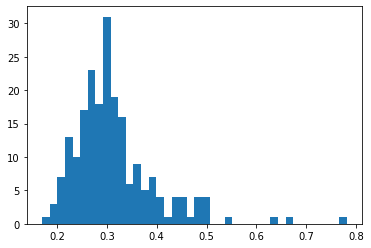

In [7]:
plt.hist([score for score in scores], bins=40)
plt.show()

some trial

In [8]:
def tokenize(sent):
    return nltk.tokenize.word_tokenize(sent)

In [9]:
evaluate(tokenize('moku mi li kili palisa.'))
evaluate(tokenize('moku mi li kili pi palisa.'))
evaluate(tokenize('moku mi li palisa kili.'))
evaluate(tokenize('moku mi li palisa pi kili.'))
None

,moku,mi,li,kili,palisa,.,Fluency
prob,1.27,25.89,97.44,0.04,0.02,98.51,0.211


,moku,mi,li,kili,pi,palisa,.,Fluency
prob,0.97,15.75,93.09,0.21,8.69,0.16,98.44,0.245


,moku,mi,li,palisa,kili,.,Fluency
prob,1.24,26.66,93.26,0.07,0.03,98.66,0.221


,moku,mi,li,palisa,pi,kili,.,Fluency
prob,0.88,16.23,82.02,0.21,7.23,0.49,98.73,0.251


In [10]:
evaluate(tokenize('nimi namako li nimi pu ala.'), True)
evaluate(tokenize('nimi namako li nimi pi pu ala.'), True)
evaluate(tokenize('nimi pi namako li nimi pi pu ala.'), True)
None

,nimi,namako,li,nimi,pu,ala,.,Fluency
prob,3.06,0.0,74.83,0.1,0.02,1.96,91.24,0.17


,nimi,namako,li,nimi,pi,pu,ala,.,Fluency
prob,1.67,0.0,51.39,0.65,45.6,0.08,2.02,94.22,0.201


,nimi,pi,namako,li,nimi,pi,pu,ala,.,Fluency
prob,1.68,20.59,0.0,12.68,0.49,33.39,0.09,2.75,94.22,0.203
